# Import Libraries

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import re
import matplotlib.pyplot as plt
pd.options.display.max_columns = 100

# Import dataset

In [2]:
# Importing listings.csv
df = pd.read_csv('../data/listings.csv')

# Showing first 5 rows
df.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11551,https://www.airbnb.com/rooms/11551,20210411033700,2021-04-19,Arty and Bright London Apartment in Zone 2,Unlike most rental apartments my flat gives yo...,Not even 10 minutes by metro from Victoria Sta...,https://a0.muscache.com/pictures/b7afccf4-18e5...,43039,https://www.airbnb.com/users/show/43039,Adriano,2009-10-03,"London, England, United Kingdom","Hello, I'm a friendly Italian man with a posit...",within an hour,100%,81%,f,https://a0.muscache.com/im/pictures/user/5f182...,https://a0.muscache.com/im/pictures/user/5f182...,Brixton,0.0,0.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"London, United Kingdom",Lambeth,NaN,51.46095,-0.11758,Entire apartment,Entire home/apt,4,NaN,1 bath,1.0,3.0,"[""Hair dryer"", ""Essentials"", ""Washer"", ""Lockbo...",$110.00,2,1125,2.0,2.0,1125.0,1125.0,2.0,1125.0,NaN,t,0,14,44,220,2021-04-19,193,1,0,2010-03-21,2021-02-21,91.0,9.0,9.0,10.0,10.0,9.0,9.0,NaN,t,2,2,0,0,1.43
1,13913,https://www.airbnb.com/rooms/13913,20210411033700,2021-04-17,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,Finsbury Park is a friendly melting pot commun...,https://a0.muscache.com/pictures/miso/Hosting-...,54730,https://www.airbnb.com/users/show/54730,Alina,2009-11-16,"London, England, United Kingdom",I am a Multi-Media Visual Artist and Creative ...,within an hour,100%,NaN,f,https://a0.muscache.com/im/users/54730/profile...,https://a0.muscache.com/im/users/54730/profile...,LB of Islington,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,t,"Islington, Greater London, United Kingdom",Islington,NaN,51.56861,-0.11270,Private room in apartment,Private room,2,NaN,1 shared bath,1.0,0.0,"[""Kitchen"", ""Host greets you"", ""Bed linens"", ""...",$40.00,1,29,1.0,1.0,29.0,29.0,1.0,29.0,NaN,t,2,2,2,2,2021-04-17,21,0,0,2010-08-18,2020-02-22,97.0,10.0,10.0,10.0,10.0,9.0,9.0,NaN,f,2,1,1,0,0.16
2,15400,https://www.airbnb.com/rooms/15400,20210411033700,2021-04-16,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,It is Chelsea.,https://a0.muscache.com/pictures/428392/462d26...,60302,https://www.airbnb.com/users/show/60302,Philippa,2009-12-05,"Kensington, England, United Kingdom","English, grandmother, I have travelled quite ...",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/60302/profile...,https://a0.muscache.com/im/users/60302/profile...,Chelsea,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"London, United Kingdom",Kensington and Chelsea,NaN,51.48780,-0.16813,Entire apartment,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Kitchen"", ""Hangers"", ""Fire extinguisher"", ""L...",$75.00,10,50,10.0,10.0,50.0,50.0,10.0,50.0,NaN,t,

# Only Select those with more than 1 reviews

In [3]:
# Select rows that have number_of_reviews more than 1
df = df.loc[df['number_of_reviews'] > 1,:].reset_index(drop=True)

# Dropping irrelevant columns

In [4]:
# Hand selecting variables that seem to not be relevant to the machine learning model
vars_todrop = ['has_availability','description','neighborhood_overview','host_about','id','listing_url','scrape_id','availability_30','last_scraped','name','picture_url','host_name','host_id','host_url','host_location','host_thumbnail_url','host_picture_url','neighbourhood','neighbourhood_group_cleansed','bathrooms','availability_60','availability_90','availability_365','calendar_last_scraped','first_review','last_review']

# Drop the selected variables
df.drop(vars_todrop,axis=1,inplace=True)

# Showing the dimension of the datafram
df.shape

(43754, 48)

# Viewing columns with missing values

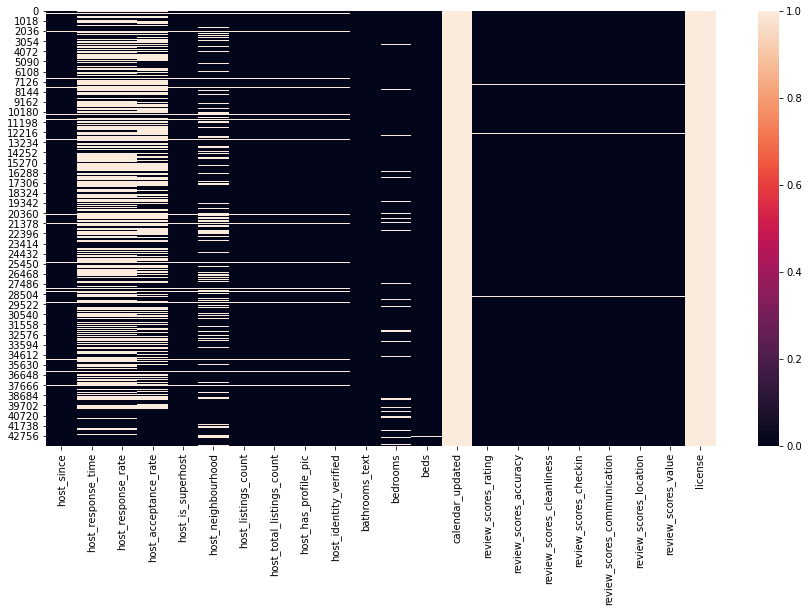

In [5]:
# Boolean of those variables that have missing values
boolean = df.isnull().sum() > 0

# Only selecting those variables that have missing values
missing_cols = df.columns[boolean]

# Visualizing the proportion of missing data
plt.figure(figsize=(15,8))
sns.heatmap(df[missing_cols].isnull())
plt.show()

# Dropping columns with more than 20% missing values

In [6]:
missing_series = df[missing_cols].isnull().sum()*100 / df.shape[0]    # Percentage of missing values in each variable
var_todrop = df[missing_cols].columns[missing_series > 20].tolist()   # Extracting name of those that have more than 20% missing values
df.drop(var_todrop,axis=1,inplace=True)                               # Dropping those variables

# Creating imputing dictionary for missing values

In [7]:
vars_numeric = [var for var in df.columns if df[var].dtype != 'object' and var != 'price']
vars_category = [var for var in df.columns if var not in vars_numeric and var != 'price']
missing_cols = df.columns[df.isnull().sum() > 0]

# Extract the median of the variable to be the imputing value (NUMERIC ONLY)
impute_numeric = df[missing_cols].median().to_dict()

# Extract the most popular value to be the imputating value (CATEGORY ONLY)
impute_category = {}
for c in vars_category :
    value_impute = df[c].value_counts().index.tolist()[0]
    impute_category[c] = value_impute

# Merge 2 impute dictionary together
impute_dict = {**impute_numeric, **impute_category}

# Imputing values that have missing rows and columns
for c in missing_cols:
    mask = df[c].isnull()
    df.loc[mask,c] = impute_dict[c]

# Clean host_since variable

In [8]:
df['host_since'][:3]

0    2009-10-03
1    2009-11-16
2    2009-12-05
Name: host_since, dtype: object

In [9]:
def clean_host_since(string):
    """
    Convert 2009-10-03  to 2009
    Changing into integer
    Calculate years old by 2021 - 2009
    """
    string = string[:4]
    integer = int(string)
    old = 2021 - integer
    return old 
df['host_years']  = df['host_since'].apply(clean_host_since)
df.drop('host_since',axis=1,inplace=True)

# Clean host_verifications

### The problems

In [10]:
df['host_verifications'].head(3)

0    ['email', 'phone', 'reviews', 'jumio', 'offlin...
1    ['email', 'phone', 'facebook', 'reviews', 'off...
2    ['email', 'phone', 'reviews', 'jumio', 'govern...
Name: host_verifications, dtype: object

### Removing ] ['' 

In [11]:
def clean_array(string):
    """
    Remove (['""'])
    """
    string = re.sub(r'[\[\]\'\" ]','',string)
    return string

df['host_verifications'] = df['host_verifications'].apply(clean_array)
df['host_verifications'].head(3)

0    email,phone,reviews,jumio,offline_government_i...
1    email,phone,facebook,reviews,offline_governmen...
2              email,phone,reviews,jumio,government_id
Name: host_verifications, dtype: object

### Extracting unique verifications

In [12]:
df['host_verifications']

0        email,phone,reviews,jumio,offline_government_i...
1        email,phone,facebook,reviews,offline_governmen...
2                  email,phone,reviews,jumio,government_id
3        email,phone,reviews,jumio,offline_government_i...
4        email,phone,reviews,offline_government_id,self...
                               ...                        
43749                                          email,phone
43750                         email,phone,facebook,reviews
43751    email,phone,jumio,offline_government_id,selfie...
43752                                          email,phone
43753                                          email,phone
Name: host_verifications, Length: 43754, dtype: object

In [13]:
# Extracting unique verifcations
unique_verification = []

# Looping through rows
for i in range(df.shape[0]):
    # Split by ','
    veri_array = df['host_verifications'][i].split(',')
    
    #Looping through each element after spliiting
    for element in veri_array:
        
        # Append its element into unique_verifcation
        unique_verification.append(element)

        # Remove those duplicates
        unique_verification = list(set(unique_verification))

print(unique_verification)
unique_verification = unique_verification[1:]
print('\n')
print(unique_verification)

['', 'sent_id', 'zhima_selfie', 'selfie', 'sesame', 'weibo', 'manual_online', 'google', 'facebook', 'email', 'photographer', 'None', 'government_id', 'phone', 'sesame_offline', 'work_email', 'identity_manual', 'reviews', 'jumio', 'offline_government_id', 'manual_offline', 'kba']


['sent_id', 'zhima_selfie', 'selfie', 'sesame', 'weibo', 'manual_online', 'google', 'facebook', 'email', 'photographer', 'None', 'government_id', 'phone', 'sesame_offline', 'work_email', 'identity_manual', 'reviews', 'jumio', 'offline_government_id', 'manual_offline', 'kba']


### Creating dummy variables

In [14]:
for veri in unique_verification:
    df[veri] = df['host_verifications'].apply(lambda x:1 if veri in x else 0)
df[['host_verifications','email','reviews']].head()

,host_verifications,email,reviews
0,"email,phone,reviews,jumio,offline_government_i...",1,1
1,"email,phone,facebook,reviews,offline_governmen...",1,1
2,"email,phone,reviews,jumio,government_id",1,1
3,"email,phone,reviews,jumio,offline_government_i...",1,1
4,"email,phone,reviews,offline_government_id,self...",1,1


### Dropping host_verification

In [15]:
df.drop('host_verifications',axis=1,inplace=True)

# Cleaning Amenities

### The problems

In [16]:
df['amenities'].head(3)

0    ["Hair dryer", "Essentials", "Washer", "Lockbo...
1    ["Kitchen", "Host greets you", "Bed linens", "...
2    ["Kitchen", "Hangers", "Fire extinguisher", "L...
Name: amenities, dtype: object

### removing [" "] then lower case then replace space with _

In [17]:
df['amenities'] = df['amenities'].str.replace('", "',',').str.replace(' ','_').str.lower()
df['amenities'] = df['amenities'].apply(clean_array)
df['amenities'].head(3)

0    hair_dryer,essentials,washer,lockbox,iron,carb...
1    kitchen,host_greets_you,bed_linens,hangers,fir...
2    kitchen,hangers,fire_extinguisher,long_term_st...
Name: amenities, dtype: object

### Extracting unique amenities

In [18]:
# Similar to host_verifcations
unique_amenities = []
for i in range(df.shape[0]):
    ame_array = df['amenities'][i].split(',')
    for element in ame_array:
        unique_amenities.append(element)
        unique_amenities = list(set(unique_amenities))
print(len(unique_amenities))

716


### Since there will be too many dummy variables, we can swap the calculating the length of amenities

In [19]:
def length_amenities(string):
    """
    return number of amenities by splitting ',' then count number of items
    """
    array = string.split(',')
    if '' in array:
        array.remove('')
    return len(array)
df['num_amenities'] = df['amenities'].apply(length_amenities)
df.drop('amenities',axis=1,inplace=True)

# Cleaning Price

In [20]:
# Extracting all the number in price
df['price'] = df['price'].str.extract(r'(\d+)')[0]

# Changing into integer
df['price'] = df['price'].astype(int)

# Removing Outliers

In [21]:
# Only selecting price in range [15,150] per night
df = df.loc[(df['price'] >14) & (df['price'] < 151),:].reset_index(drop=True)

# Only selecting listing with less than 10 number of beds
df = df.loc[df['beds'] < 10,:]

# Transforming t/f to 1/0

In [22]:
tf = ['host_is_superhost','host_has_profile_pic','host_identity_verified','instant_bookable']
for c in tf:
    df[c] = df[c].apply(lambda x: 1 if x=='t' else 0)

# -------------------------------------------------------------------- BUILDING MODEL --------------------------------------------------------------------

In [23]:
from catboost import CatBoostRegressor, Pool, cv, CatBoostClassifier
import pandas as pd
import numpy as np
import pickle

# Calculating MAE between predictions and true labels
def fn_MAE(actuals, predictions):
    
    return np.mean(np.abs(predictions - actuals))

# Calculating RMSE between predictions and true labels
def fn_RMSE(actuals, predictions):
    return np.sqrt(np.mean((predictions - actuals)**2))

In [24]:
### Dependent variable
var_dep = ['price']

### Categorical variables
vars_category = [var for var in df.columns if df[var].dtype != 'float' and df[var].dtype != 'int']

### Numerical variables
vars_numeric = [var for var in df.columns if var not in var_dep + vars_category]

### Indepedent variables
vars_ind = vars_category + vars_numeric

# Separating Train and Test set with test size = 20% of original dataframe

In [25]:
from sklearn.model_selection import train_test_split
X = df[vars_ind]
y = df[var_dep]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

# Separating validation set within train set

In [26]:
np.random.seed(42)
df_train = pd.concat([X_train,y_train],axis=1)
df_train['fold'] = np.random.randint(0,8,df_train.shape[0])


idx_train  = df_train['fold'].isin(range(8))
idx_val    = df_train['fold'].isin([6,7])
idx_design = df_train['fold'].isin(range(8))

df_X_all = df_train[idx_design][vars_ind]
y = df_train[var_dep].values

# CatBoostRegressor with selected parameters

In [27]:
model2 = CatBoostRegressor(iterations=4000,
                        use_best_model=True,
                        eval_metric='RMSE',          
                        od_type='Iter',
                        od_wait=20,
                        border_count=128,
                        model_size_reg=0,
                        ctr_leaf_count_limit=None,
                        leaf_estimation_method = 'Gradient',
                        max_ctr_complexity=4,
                        learning_rate=0.03,

                        boosting_type='Plain',
                        bootstrap_type='Bernoulli',
                        one_hot_max_size=10,
                        task_type='CPU',
                        #By default, the learning rate is defined automatically 
                        #based on the dataset properties and the number of 
                        #iterations. The automatically defined value should 
                        #be close to the optimal one. ## default 0.03
                        depth=6, 
                        l2_leaf_reg=10, # default is 3
                        loss_function='RMSE', #I could not get MAE to work,
                        random_seed=14,
                        logging_level='Silent'
                        )

model2.fit(df_X_all[idx_design], y[idx_design],
            cat_features=vars_category,
            eval_set=(df_X_all[idx_val], y[idx_val]),
            plot=True)



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

# Calculating MAE and RMSE of validation error

In [28]:
pred_val   = model2.predict(df_X_all[idx_val])
print('val error',   fn_MAE(y[idx_val],   pred_val))
print('RMSE val error', fn_RMSE(y[idx_val],   pred_val))

val error 37.17845471209465
RMSE val error 45.94615255577482


# Predicting Test set and calculating its R-Squared

In [29]:
pred_test   = model2.predict(X_test)

from sklearn.metrics import r2_score
r2_score(y_test, pred_test)

0.7066522684983745

# Drawing its variable importance

In [30]:
scores = model2.feature_importances_.tolist()
column_name = X_train.columns.tolist()

barchart = pd.DataFrame({
    'variables':column_name,
    'scores':scores
})
barchart = barchart.sort_values('scores',ascending=True)
barchart = barchart.tail(20)
barchart['scores'] = barchart['scores']*100 / barchart['scores'].max()


# Visualizing variables importance

Text(0.5, 1.0, 'Variable Importance')

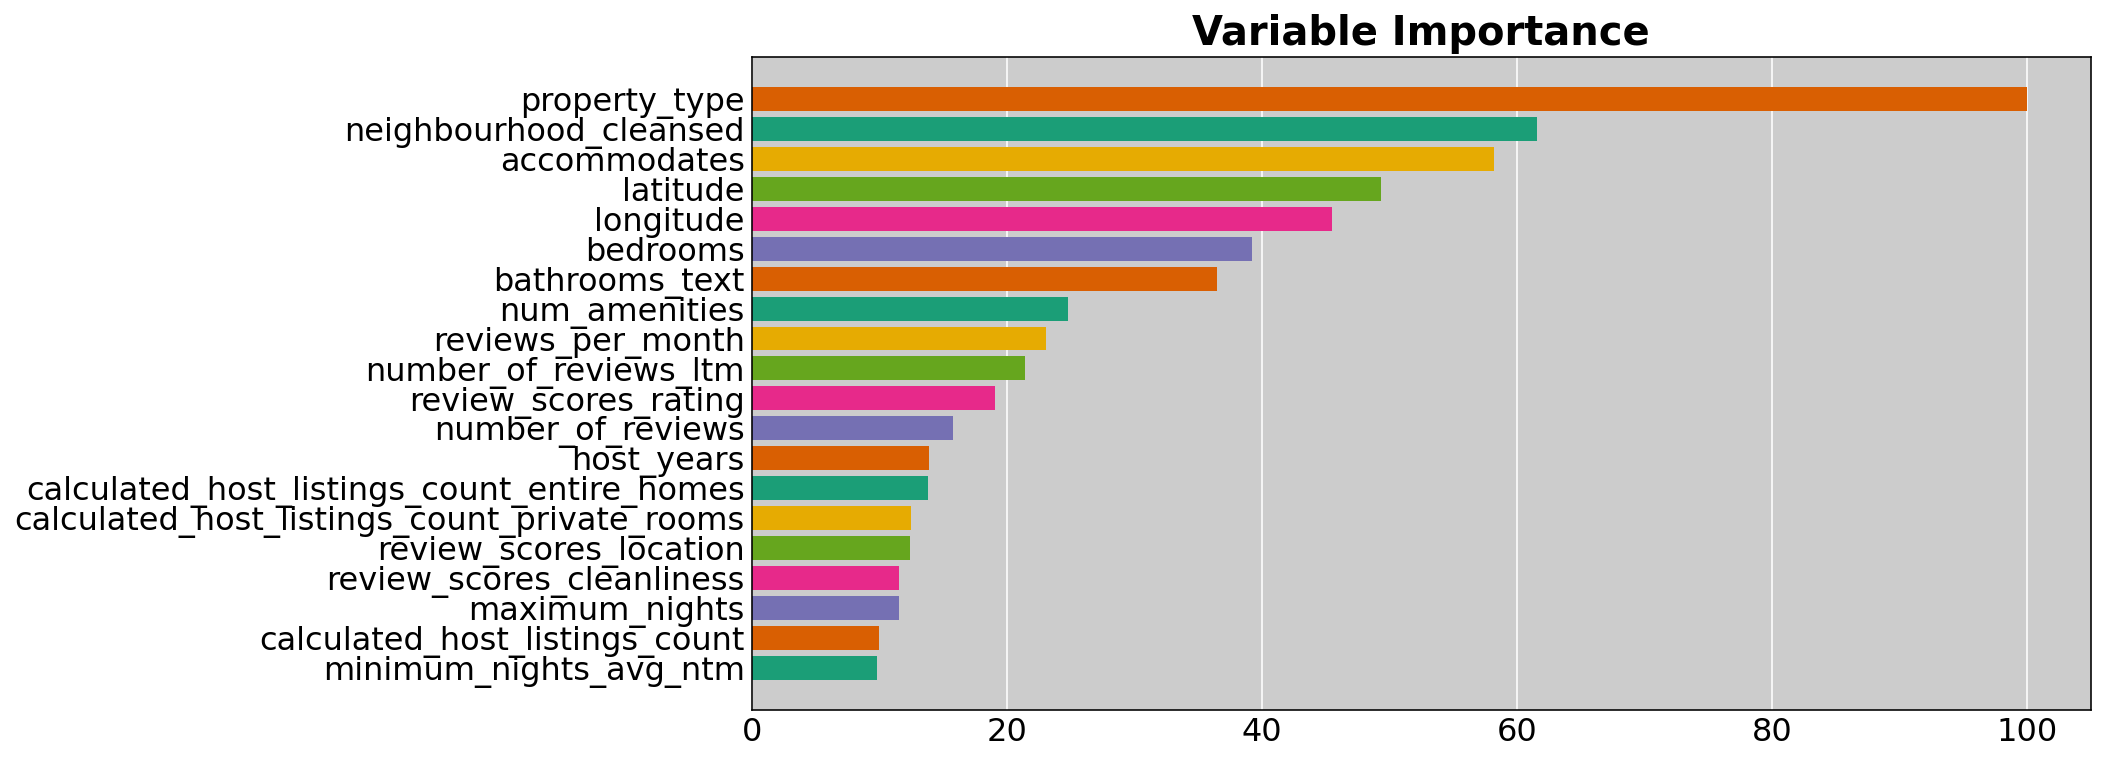

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 6), dpi=144)
colors = plt.cm.Dark2(range(6))
y = barchart.variables
width = barchart.scores

ax.barh(y=y, width=width, color=colors)
ax.set_facecolor('.8')
ax.tick_params(labelsize=16, length=0)
ax.grid(True,axis='x',color='white')
ax.set_axisbelow(True)
ax.set_title('Variable Importance',fontsize=20,fontweight=600)

### Comment

- Gradient Boosted Algorithm with selected parameters achieved 0.7 R-Squared value which is considered to be substantial
- According to the variable importance of the gradient boosted algorithm, property type and neighbourhood have the largest impact on the price of the listing
- Number of amenities and number of reviews of the listing barely influence the price of the listing.